(chap_binary)=
(chap_morph)=
# Morphological operations

:::{admonition} Chapter outline
:class: tip

* **Morphological operations** can be used to refine or modify the shapes of objects in images
* Many morphological operations can be applied to **binary images** to improve an image segmentation
* **Grayscale morphological operations** can also be used as processing steps before binarization, or to help identify regional maxima and minima
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Image filters and thresholds enable us to detect structures of various shapes and sizes for different applications.
Nevertheless, despite our best efforts, the binary images produced by our thresholds often still contain inaccurate or undesirable detected regions.
They could benefit from some extra cleaning up.

At this stage, we are primarily working with shapes -- morphology -- so most of the techniques we describe here are often called **morphological operations**.

## Morphological operations using rank filters

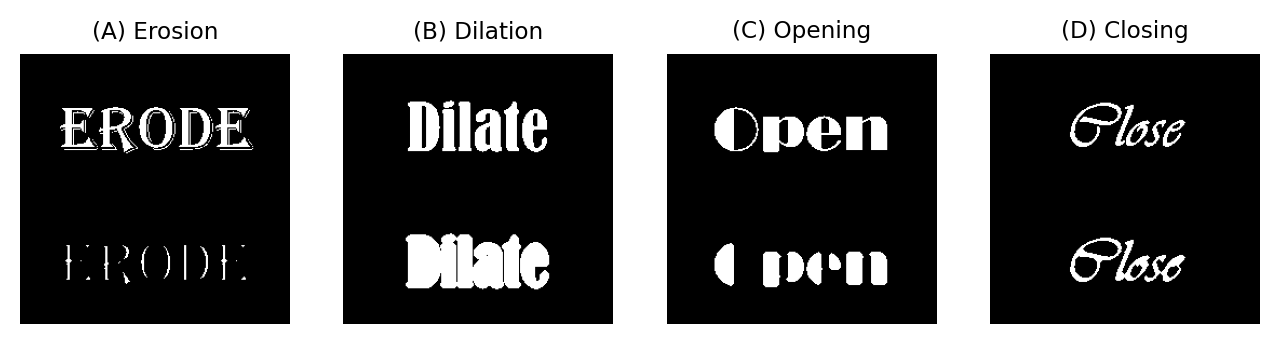

In [2]:
"""
Show morphological operations.

Note that, as a habit, I use 'bw_' at the beginning of variable names for
variables that are really binary (black/white) images to identify these
from other images, for which I use 'im_'.
"""

def create_disk(radius: int):
    """
    Create a circular structuring element.
    This is essentially the binary/morphological equivalent the filter kernel.
    """
    r = radius
    x = np.arange(-r, r+1)
    y = np.arange(-r, r+1)
    y, x = np.meshgrid(x, x)
    return x*x + y*y <= r*r

# Create structuring element
radius = 2
strel = create_disk(radius)

# Erode, dilate, open & close the corresponding images
# Use > 0 when reading to ensure they are binary ('bool') arrays,
# not 8-bit images that happen to just have two values in them.
bw_erode = load_image('images/morph_erode.png') > 0
bw_eroded = ndimage.binary_erosion(bw_erode, structure=strel)

bw_dilate = load_image('images/morph_dilate.png') > 0
bw_dilated = ndimage.binary_dilation(bw_dilate, structure=strel)

bw_open = load_image('images/morph_open.png') > 0
bw_opened = ndimage.binary_opening(bw_open, structure=strel)

bw_close = load_image('images/morph_close.png') > 0
bw_closed = ndimage.binary_closing(bw_close, structure=strel)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 4))

show_image(np.vstack((bw_erode, bw_eroded)), title="(A) Erosion", pos=141)
show_image(np.vstack((bw_dilate, bw_dilated)), title="(B) Dilation", pos=142)
show_image(np.vstack((bw_open, bw_opened)), title="(C) Opening", pos=143)
show_image(np.vstack((bw_close, bw_closed)), title="(D) Closing", pos=144)
glue_fig('fig_erode_dilate_open', fig)

```{glue:figure} fig_erode_dilate_open
---
align: center
name: fig-erode_dilate_open
---
Overview of erosion, dilation, opening and closing.
The original image is shown at the top, while the processed part is at the bottom in each case.
```

### Erosion & dilation

Our first two morphological operations, **erosion** and **dilation**, are actually identical to minimum and maximum filtering respectively, described [in the previous chapter](sec_filters_rank).
The names erosion and dilation are used more often when speaking of binary images, but the operations are the same irrespective of the kind of image.

```{admonition} Structuring elements
The neighborhood used to calculate the result for each pixel is defined by a **structuring element**.
This is similar to a [filter kernel](sec_filters_linear), except that it only has values 0 and 1 (for ignoring or including the neighborhood pixel, respectively).
```

```{margin}
Here, we assume the background value in our binary image is 0 (black) and foreground is 1 (white).
```

**Erosion** will make objects in the binary image smaller, because a pixel will be set to the background value if _any_ other pixels in the neighborhood are background.
This can split single objects into multiple pieces.

Conversely, **dilation** makes objects bigger, since the presence of a single foreground pixel anywhere in the neighborhood will result in a foreground output.
This can also cause objects to merge.

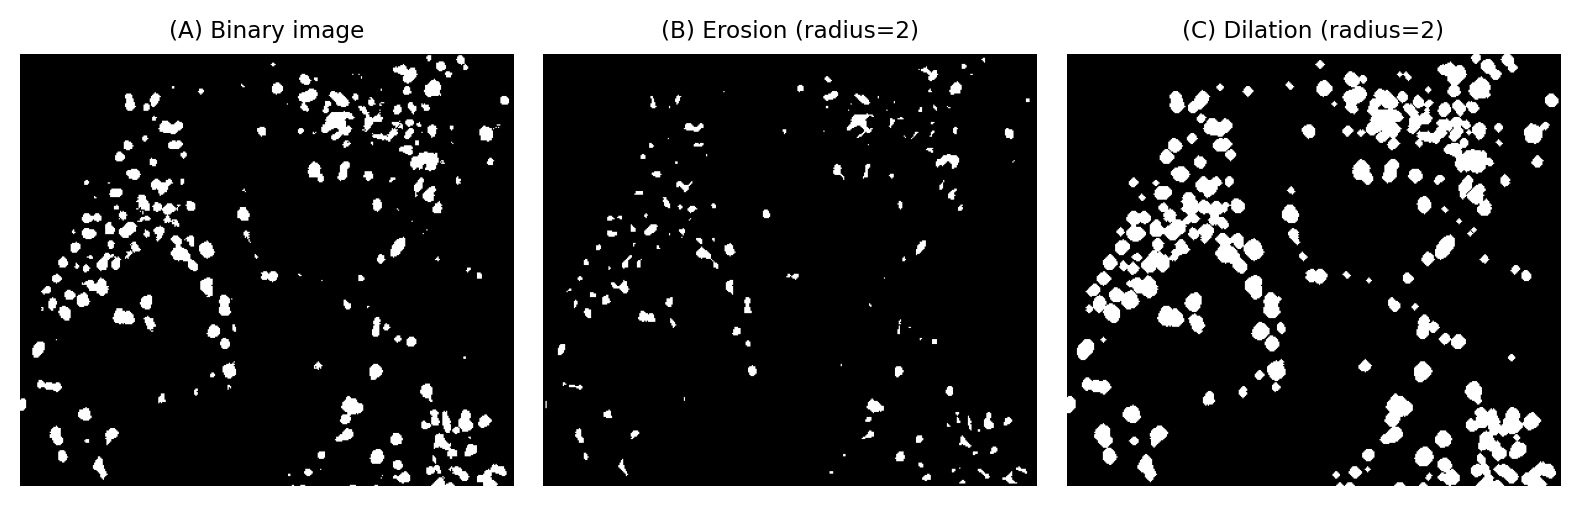

In [3]:
def load_spots() -> np.ndarray:
    im = load_image('hela-cells.zip')[50:400, 50:450, 0].astype(np.float32)
    return im

def load_binary_spots(method='median') -> np.ndarray:
    """
    Create a small, imperfect binary image containing spots.
    We don't try to optimize preprocessing or thresholds - we just want something for illustration.
    """
    import skimage.filters as filters
    import skimage.morphology as morph

    im = load_spots()
    if method == 'median':
        im_bg = ndimage.median_filter(im, (15, 15))
        im = im - im_bg
    elif method == 'opening':
        im_bg = morph.opening(im, morph.disk(10))
        im = im - im_bg
    elif method == 'dog':
        sigma = 2.5
        im = filters.gaussian(im, sigma) - filters.gaussian(im, sigma*1.6)
    bw = im > filters.threshold_triangle(im)
    return bw

# Define radius (change this to update the figure!)
radius = 2

# Create structuring element
strel = create_disk(radius)

# Load image & process
bw = load_binary_spots()
bw_eroded = ndimage.binary_erosion(bw, structure=strel)
bw_dilated = ndimage.binary_dilation(bw, structure=strel)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_eroded, title=f"(B) Erosion (radius={radius})", pos=132)
show_image(bw_dilated, title=f"(C) Dilation (radius={radius})", pos=133)
plt.tight_layout()
glue_fig('fig_erode_dilate_spots', fig)

```{glue:figure} fig_erode_dilate_spots
---
align: center
name: fig-erode_dilate_spots
---
The effects of erosion and dilation on a binary image of small structures.
```

(sec_morph_opening_closing)=
### Opening & closing

The fact that erosion and dilation alone affect sizes can be a problem: we may like their abilities to merge, separate or remove objects, but prefer that they had less impact upon areas and volumes.
Combining both operations helps achieve this.

**Opening** consists of an erosion followed by a dilation.
It therefore first shrinks objects, and then expands whatever remains to _approximately_ its original size.

Such a process is not as pointless as it may first sound.
If erosion causes very small objects to completely disappear, clearly the dilation cannot make them reappear: they are gone for good.
Barely-connected objects separated by erosion are also not reconnected by the dilation step.

**Closing** is the opposite of opening, i.e. a dilation followed by an erosion, and similarly changes the shapes of objects.
The dilation can cause almost-connected objects to merge, and these often then remain merged after the erosion step.
If you wish to count objects, but they are wrongly subdivided in the segmentation, closing may help make the counts more accurate.

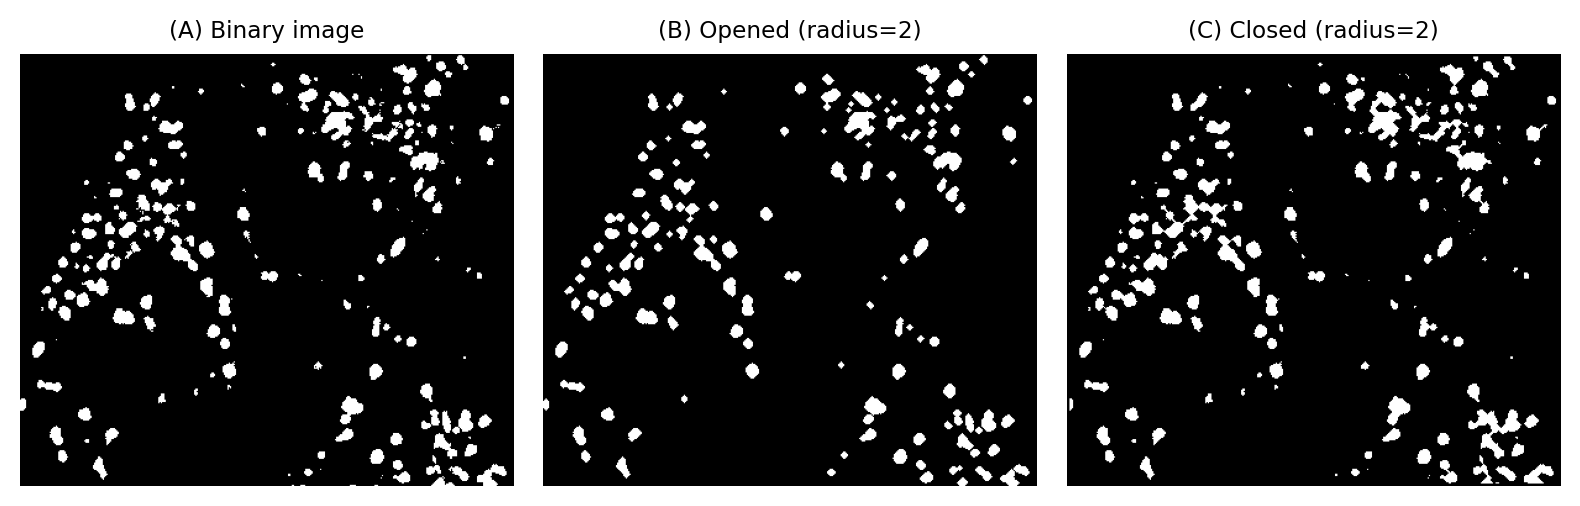

In [4]:
# Define radius (change this to update the figure!)
radius = 2

# Create structuring element
strel = create_disk(radius)

# Load image & process
bw = load_binary_spots()
bw_opened = ndimage.binary_opening(bw, structure=strel)
bw_closed = ndimage.binary_closing(bw, structure=strel)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_opened, title=f"(B) Opened (radius={radius})", pos=132)
show_image(bw_closed, title=f"(C) Closed (radius={radius})", pos=133)
plt.tight_layout()

glue_fig('fig_open_close_spots', fig)

```{glue:figure} fig_open_close_spots
---
align: center
name: fig-open_close_spots
---
The effects of opening and closing on a binary image of small structures. Unlike when using erosion or dilation alone, the sizes of objects are largely preserved although the contours are modified. Opening has the effect of completely removing the smallest or thinnest objects.
```

### Boundaries & outlines

We can make use of the operations above to identify outlines in a binary image.
To do this, we first need a clear definition of what we mean by 'outline'.

The **inner boundary** may be defined as *the foreground pixels that are adjacent to background pixels*.
We can determine the inner boundary by
* Duplicating the binary image
* Eroding with a 3×3 structuring element
* Subtracting the eroded image from the original

The **outer boundary** may be defined as *the background pixels that are adjacent to foreground pixels*.
We can determine the outer boundary by
* Duplicating the binary image
* Dilating with a 3×3 structuring element
* Subtracting the original image from the dilated image

:::{admonition} Thicker boundaries
:class: tip

There's no reason to limit outlines to being 1 pixel thick.
Choosing a larger structuring element makes it possible create thicker outlines.
We might also subtract an eroded image from a dilated image to identify a thicker boundary that contains both inner and outer pixels.

One application of creating thick boundaries in microscopy images of cells is to generate a binary image of the nuclei, and then a second binary image representing a ring around the nucleus.
This makes it possible to make measurements that are likely to be within the cytoplasm, just outside the nucleus, without the task of identifying the full area of the cell -- which is often difficult if the cell or membrane are not clearly visible.
:::

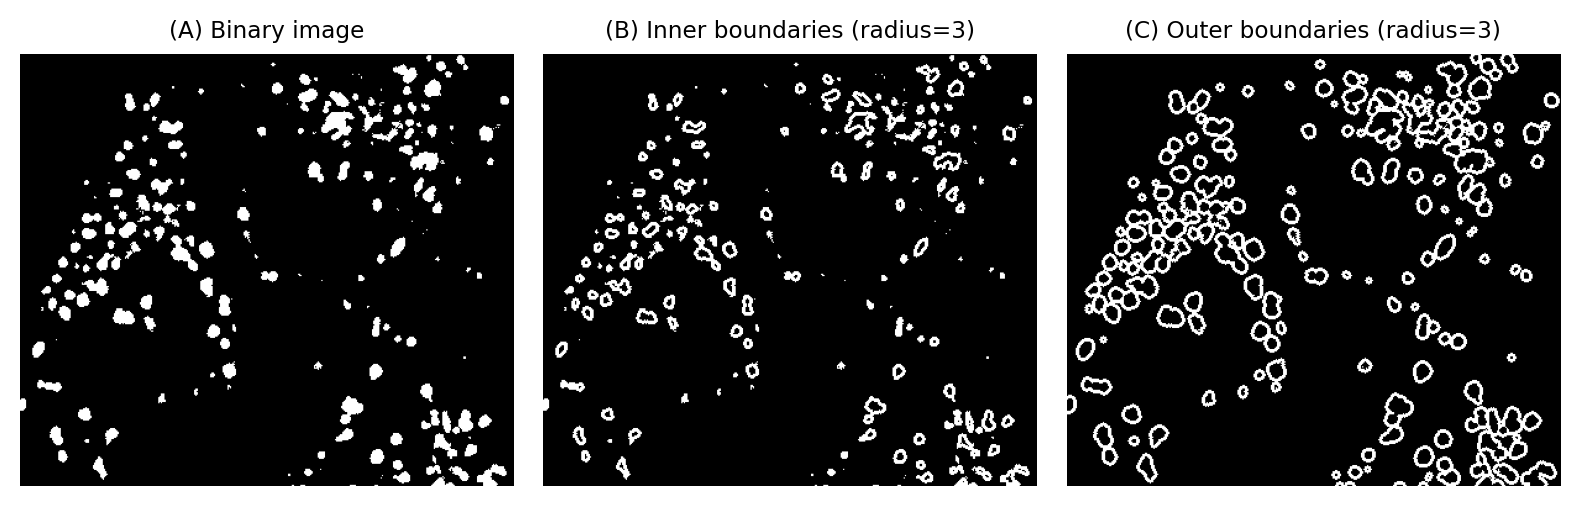

In [5]:
# Define radius (change this to update the figure!)
radius = 3

# Create structuring element
strel = create_disk(radius)

# Load image & process
bw = load_binary_spots()
bw_eroded = ndimage.binary_erosion(bw, structure=strel)
bw_dilated = ndimage.binary_dilation(bw, structure=strel)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw ^ bw_eroded, title=f"(B) Inner boundaries (radius={radius})", pos=132)
show_image(bw_dilated ^ bw, title=f"(C) Outer boundaries (radius={radius})", pos=133)
plt.tight_layout()

glue_fig('fig_binary_outlines', fig)

```{glue:figure} fig_binary_outlines
---
align: center
name: fig-binary_outlines
---
Calculating inner and outer boundaries, using erosion or dilation. The radius of the structuring element can be used to tune the boundary thickness.
```

### Finding local minima & maxima

Erosion and dilation can be used to find pixels that are **local maxima** or **local minima** very easily, with the caveat that the results are inexact and often unusable.
Nevertheless, the trick works 'well enough' sufficiently often to be worth knowing.

Here, we focus on maxima; the process for detecting local minima is identical, except that either the image should be inverted or erosion used instead of dilation.

A local maximum can be defined as a pixel with a value greater than all its neighbors, or a connected group of pixels with the same higher value than the surrounding pixels.
An easy way to detect these pixels is to dilate the image with 3×3 maximum filter, and check for pixel values that are unchanged (i.e. where the pixel was already a maximum within its neighborhood).

This is inexact because it does not *only* identify maxima; it also detections some 'plateaus' where pixels have identical values to their neighbors.
In practice, this is not always a problem because noise can make plateaus virtually non-existent for many real-world images (at least ones that haven't been clipped).

A bigger problem is that the approach often identifies far too many maxima to be useful ({numref}`fig-morph_simple_maxima`).

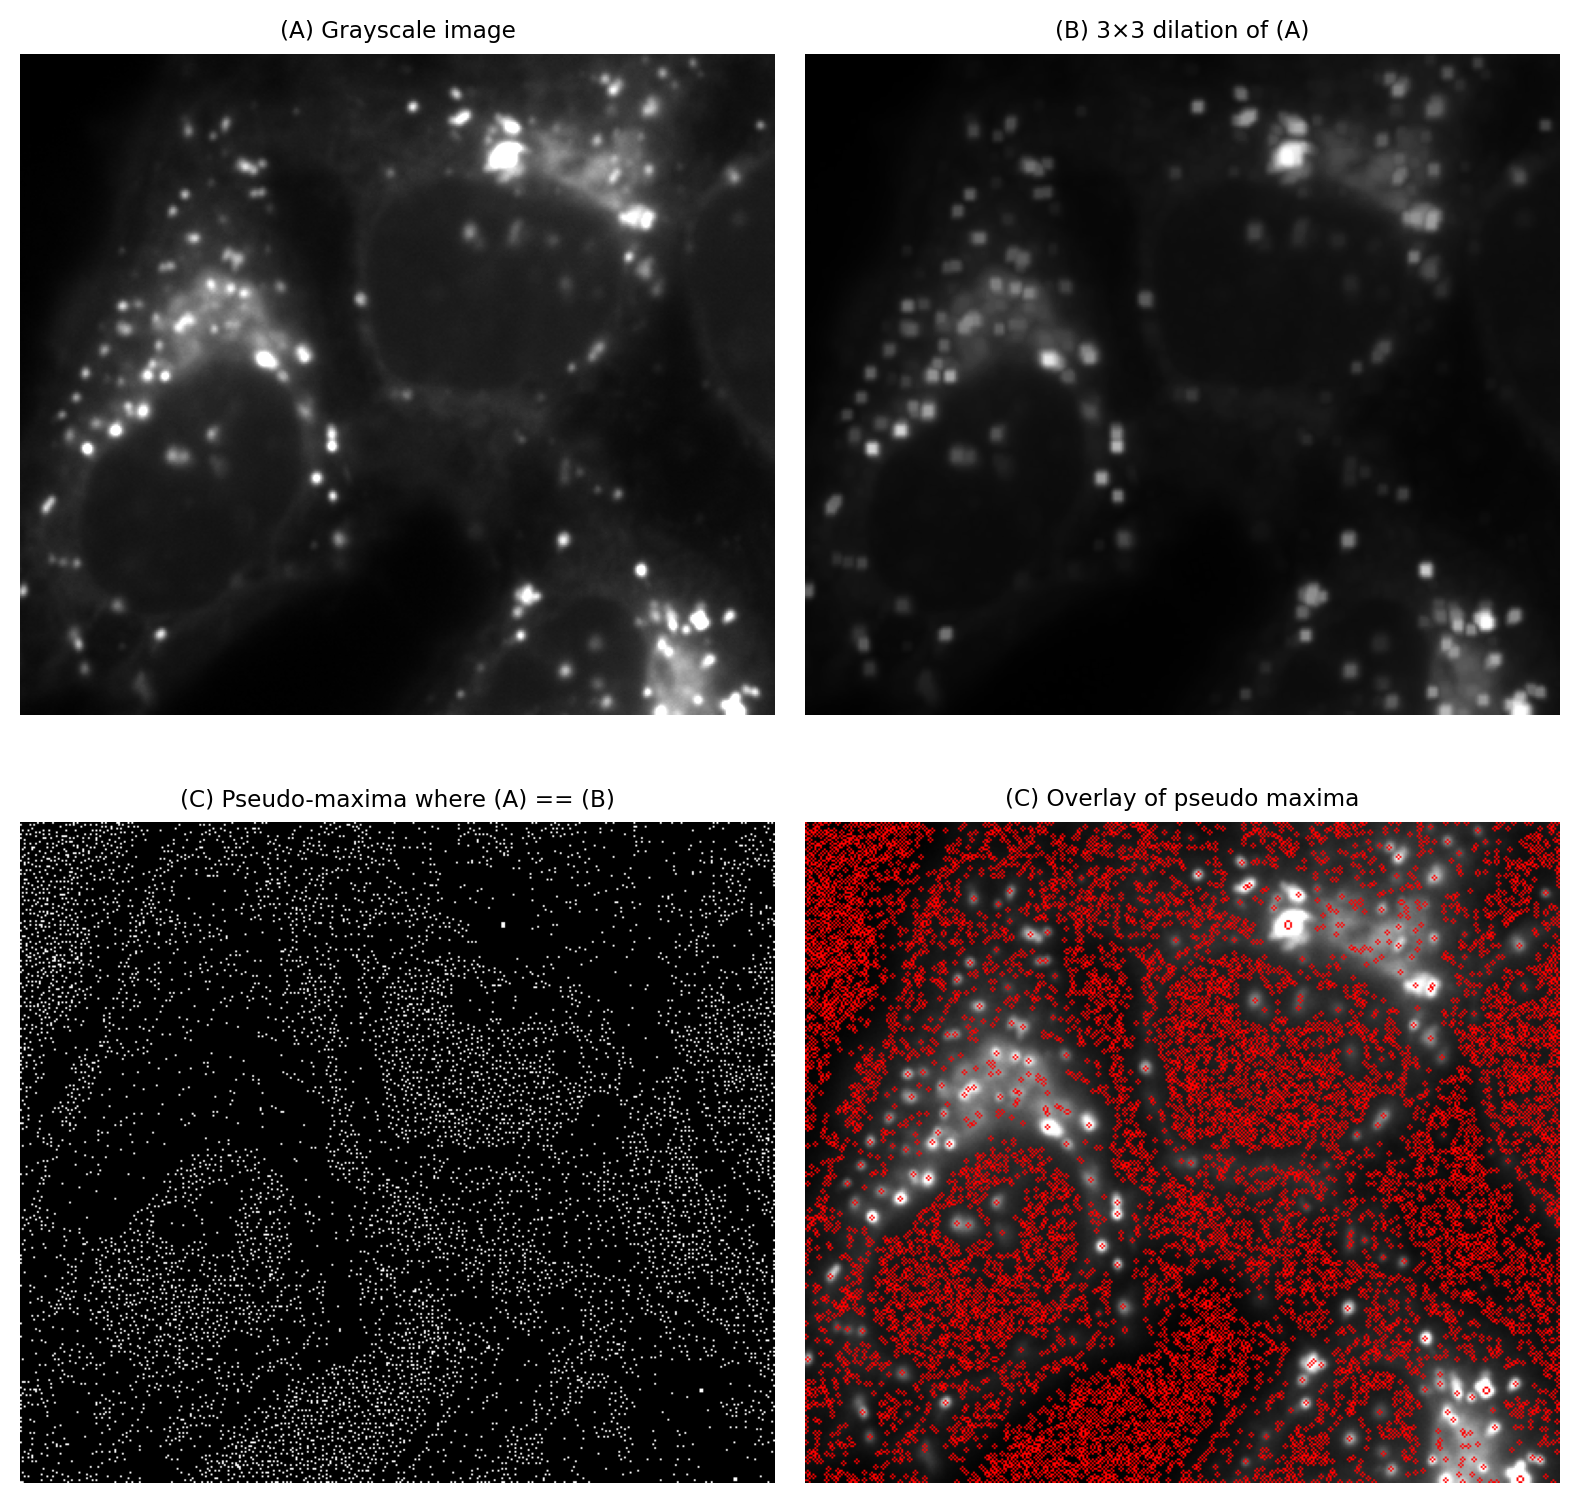

In [6]:
from skimage import morphology as morph
from skimage import filters as filters
from skimage.segmentation import mark_boundaries

# Load image & process
im = load_spots()
im_dilated = ndimage.maximum_filter(im, (3, 3))
bw = im == im_dilated
im2 = im - np.percentile(im.ravel(), 0.5)
im2 = im2 / np.percentile(im2.ravel(), 99.5)
im_boundaries = mark_boundaries(np.clip(im2, 0, 1), bw, color=(1, 0, 0))

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(im, clip_percentile=0.5, title="(A) Grayscale image", pos=221)
show_image(im_dilated, title=f"(B) 3×3 dilation of (A)", pos=222)
show_image(bw, title=f"(C) Pseudo-maxima where (A) == (B)", pos=223)
show_image(im_boundaries, title=f"(C) Overlay of pseudo maxima", pos=224)
plt.tight_layout()

glue_fig('fig_morph_simple_maxima', fig)

```{glue:figure} fig_morph_simple_maxima
---
align: center
name: fig-morph_simple_maxima
---
Identifying local maxima with the help of a 3×3 dilation tends to find too many maxima to be useful.
```

We can reduce these by either increasing the size of the maximum filter (therefore requiring pixels to be maximal across a larger region), or by pre-smoothing the image (usually with a [Gaussian filter](sec_filters_gaussian)).
However, tuning the parameters becomes difficult.

We will see an alternative approach that is often more intuitive in {ref}`sec_h_extrema`.

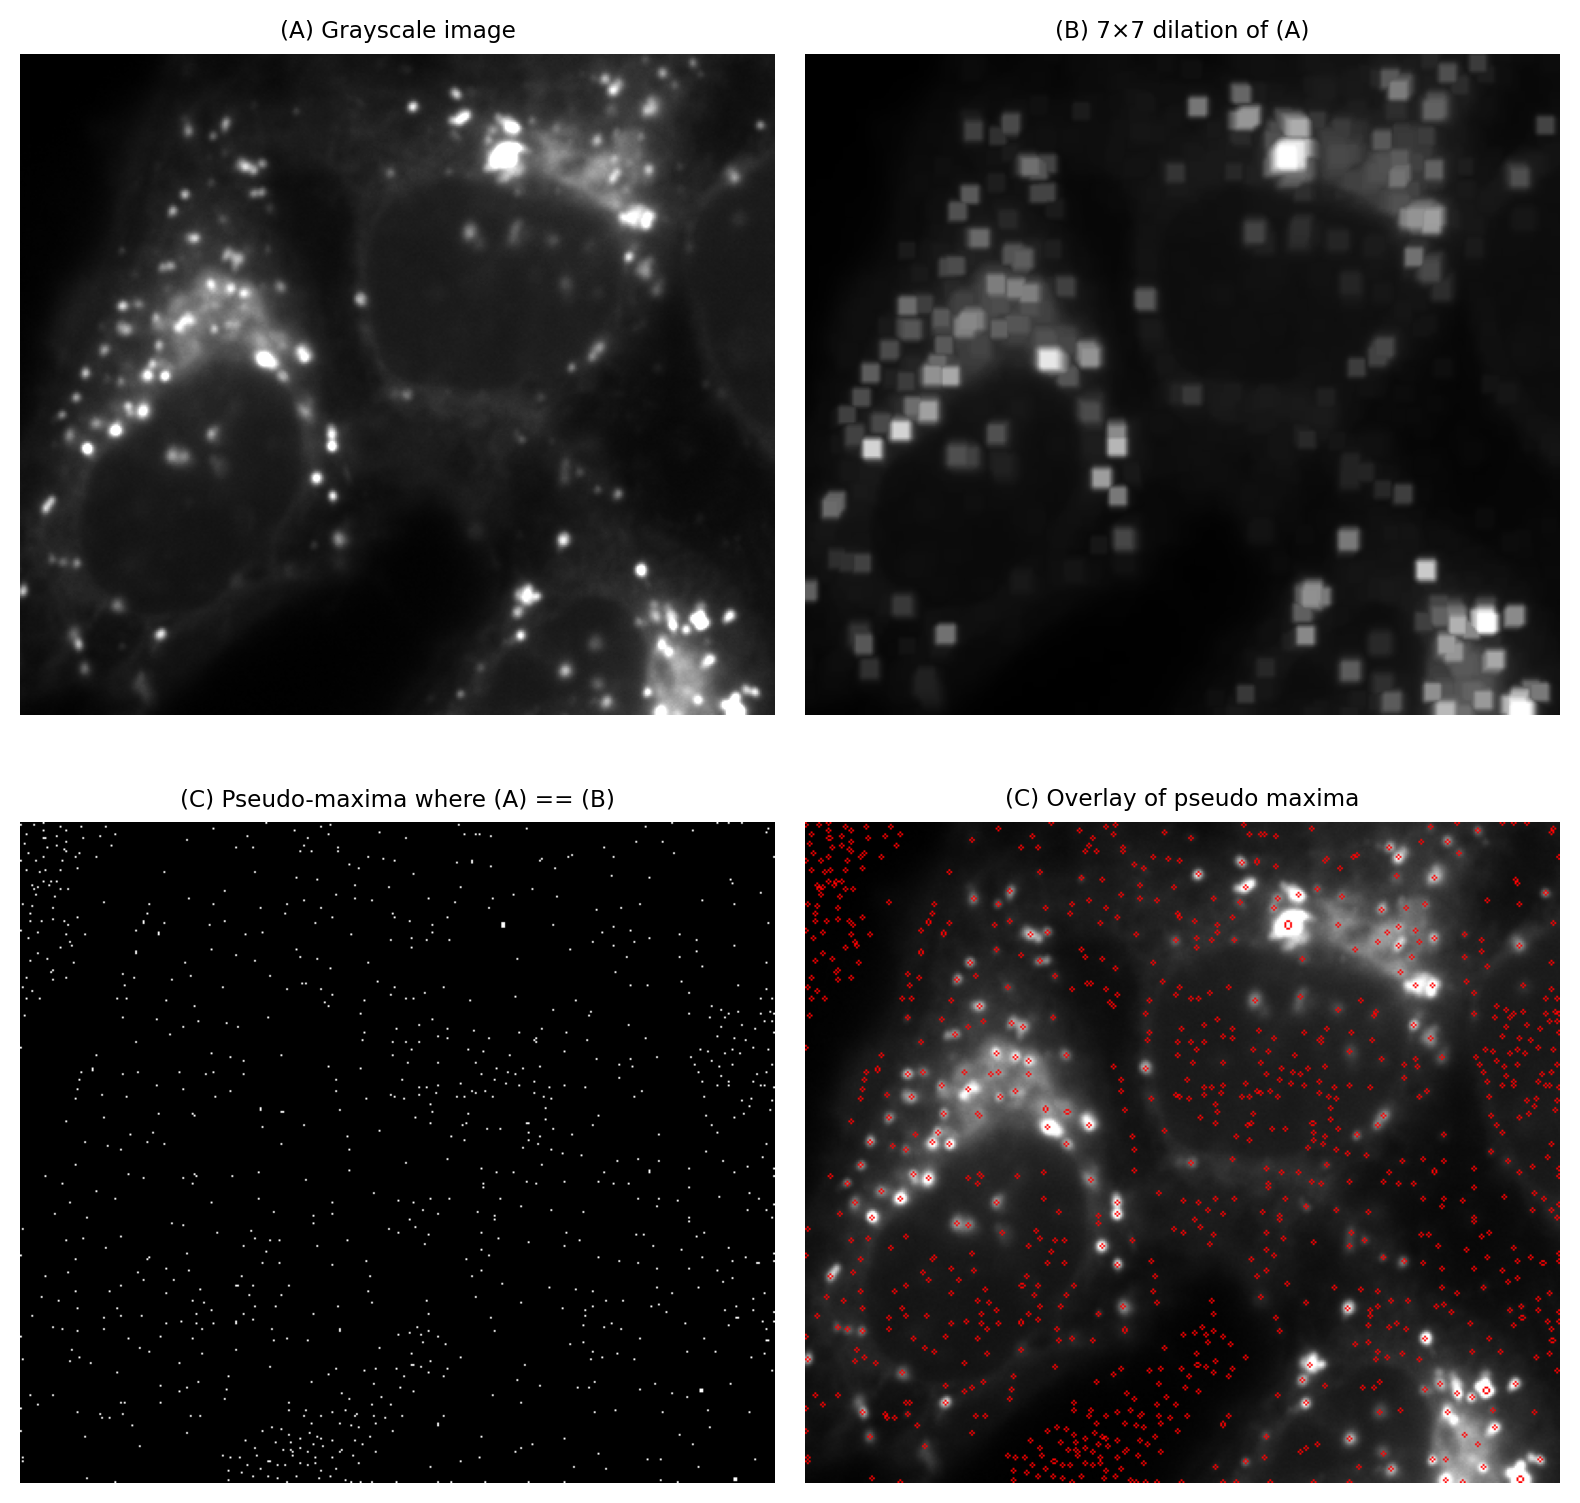

In [7]:
# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

# Load image & process
im = load_spots()
im_dilated = ndimage.maximum_filter(im, (7, 7))
bw = im == im_dilated
im2 = im - np.percentile(im.ravel(), 0.5)
im2 = im2 / np.percentile(im2.ravel(), 99.5)
im_boundaries = mark_boundaries(np.clip(im2, 0, 1), bw, color=(1, 0, 0))

show_image(im, clip_percentile=0.5, title="(A) Grayscale image", pos=221)
show_image(im_dilated, title=f"(B) 7×7 dilation of (A)", pos=222)
show_image(bw, title=f"(C) Pseudo-maxima where (A) == (B)", pos=223)
show_image(im_boundaries, title=f"(C) Overlay of pseudo maxima", pos=224)
plt.tight_layout()

glue_fig('fig_morph_simple_maxima_bigger', fig)

```{glue:figure} fig_morph_simple_maxima_bigger
---
align: center
name: fig-morph_simple_maxima_bigger
---
Identifying local maxima with the help of a larger dilation (here, 7×7 pixels) can sometimes give better results than using a smaller dilation {numref}`fig-morph_simple_maxima`.
```


## More morphological operations

### Area opening

**Area opening** is similar to *opening*, except it avoids the need for any kind of maximum or minimum filtering.

It works by identifying [**connected components** in the binary image](sec_binary_labeled), which are contiguous regions of foreground pixels.
For each connected component, the number of pixels is counted to give an area in px².
If the area of a component falls below a specified area threshold, the pixels for that component are set to the background, i.e. the component is removed.

*Area opening* is often preferable to *opening*, because it has *no impact* on the shape of any structures larger than the area threshold.
It simply applies a minimum area threshold, removing everything smaller.

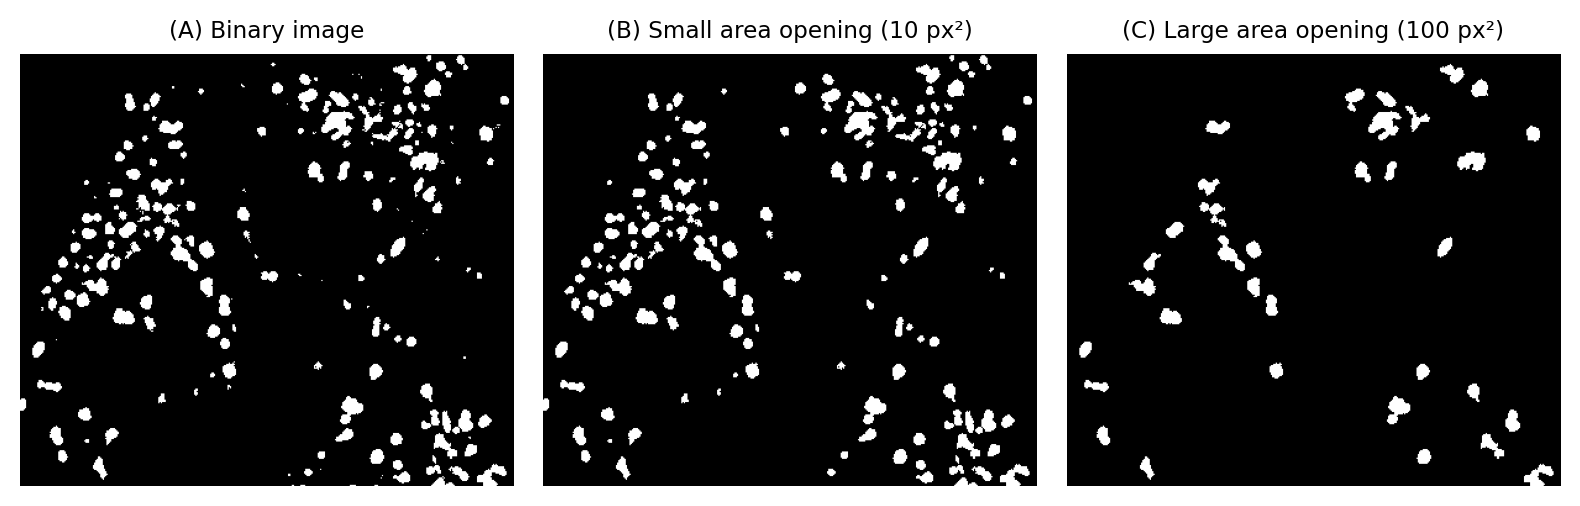

In [8]:
# Define areas (change this to update the figure!)
small_area = 10
large_area = 100

from skimage import morphology as morph

# Load image & process
bw = load_binary_spots()
bw_small_opened = morph.area_opening(bw, small_area)
bw_large_opened = morph.area_opening(bw, large_area)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_small_opened, title=f"(B) Small area opening ({small_area} px²)", pos=132)
show_image(bw_large_opened, title=f"(C) Large area opening ({large_area} px²)", pos=133)
plt.tight_layout()

glue_fig('fig_area_open_spots', fig)

```{glue:figure} fig_area_open_spots
---
align: center
name: fig-area_open_spots
---
Using area opening to remove small objects.
```

### Filling holes

**Filling holes** involves identifying connected components of *background pixels* that are entirely surrounded by foreground pixels.
These components are then 'flipped' to become foreground pixels instead.

Should we then want to identify the holes themselves, we can subtract the original image from the filled image.

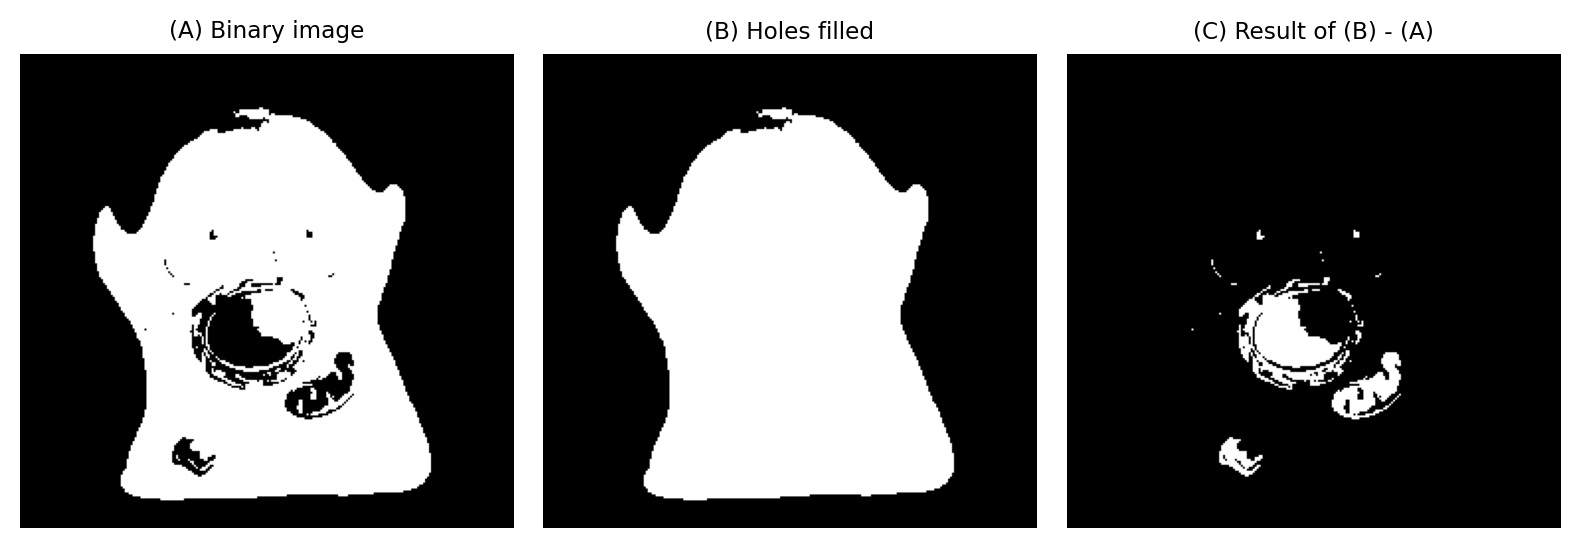

In [9]:
from skimage import morphology as morph

# Load image & process
im = load_image('happy_cell.tif')
bw = im > im.mean()
bw_filled = ndimage.binary_fill_holes(bw)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_filled, title=f"(B) Holes filled", pos=132)
show_image(bw_filled.astype(np.uint8) - bw.astype(np.uint8), title=f"(C) Result of (B) - (A)", pos=133)
plt.tight_layout()

glue_fig('fig_fill_holes_cell', fig)

```{glue:figure} fig_fill_holes_cell
---
align: center
name: fig-fill_holes_cell
---
Filling holes in a binary image. Image subtraction makes it possible to extract the holes themselves.
```

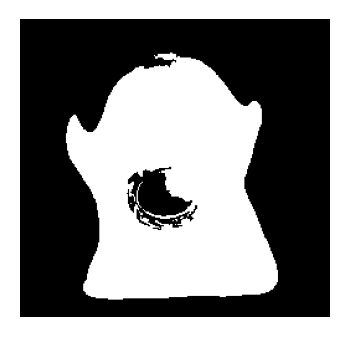

In [10]:
# Code to selective fill small holes

im = load_image('happy_cell.tif')
bw = im > im.mean()

bw2 = ~bw
bw2 = morph.area_opening(bw2, 1000)
bw2 = ~bw2

fig = create_figure(figsize=(2, 2))
show_image(bw2)
glue_fig('fig_fill_small_holes_cell', fig)

```{glue:figure} fig_fill_small_holes_cell
---
figclass: margin
---
Small holes filled.
```

````{tab-set}

```{tab-item} Question


We don't always want to fill *all* the holes within a binary image, but rather only the smaller ones.
Can you think of a way to fill *only holes smaller than 1000 px²*, using area opening?

You'll need at least one operation described in previous chapter.
```

```{tab-item} Answer

One way to fill holes below a fixed size:

* Invert the binary image
* Perform area opening with an area threshold of 1000 px²
* Invert the result

```
````

### Thinning & skeletonization

**Thinning** and **skeletonization** are related operations that aim to 'thin down' objects in a binary image to just their centerlines.
They are particularly useful with filamental or tube-like structures, such as axons or blood vessels.

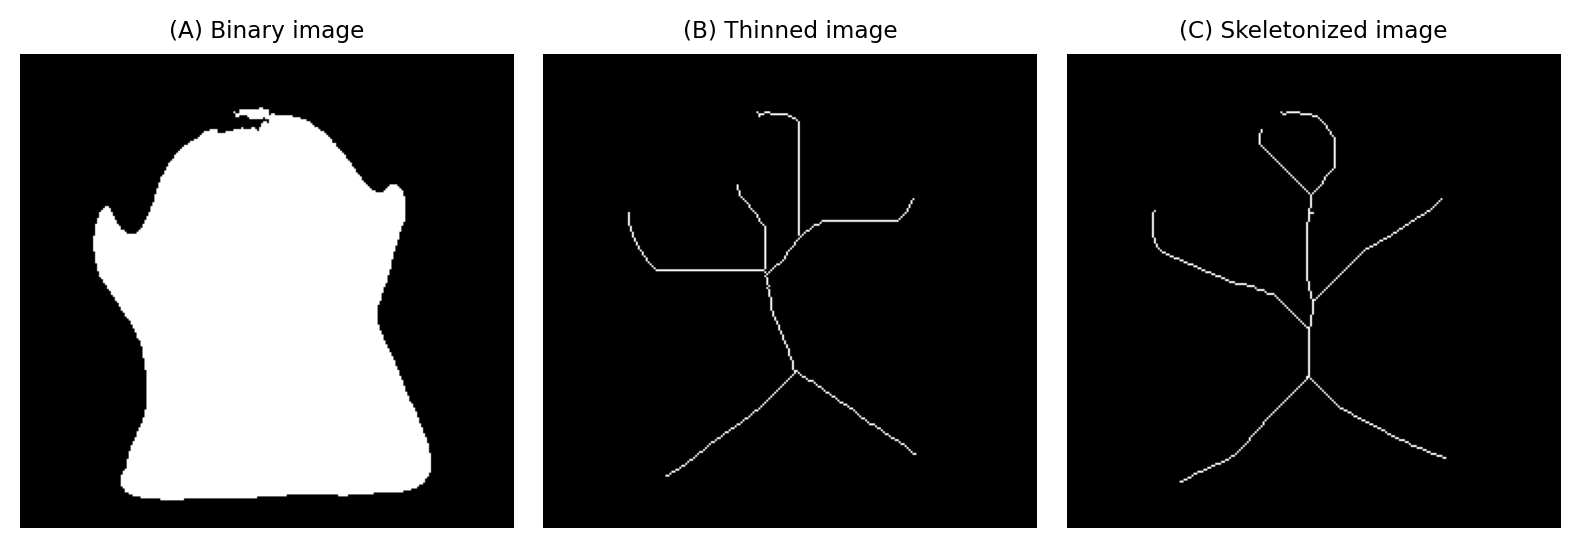

In [11]:
im = load_image('happy_cell.tif')
bw = im > im.mean()

bw = ndimage.binary_fill_holes(bw)
bw_thinned = morph.thin(bw)
bw_skeletonized = morph.skeletonize(bw)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 4))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_thinned, title="(B) Thinned image", pos=132)
show_image(bw_skeletonized, title="(C) Skeletonized image", pos=133)

plt.tight_layout()
glue_fig('fig_binary_thinning', fig)

```{glue:figure} fig_binary_thinning
---
align: center
name: fig-binary_thinning
---
The effects of thinning and skeletonization on a binary image.
```


:::{admonition} What's the difference between thinning & skeletonization?
:class: info

The truth is: I'm not entirely sure.
There is quite a bit of overlap in the literature, and I've seen the same algorithm referred to by both names.
Furthermore, there are different thinning algorithms that give different results; the situation is similar for skeletonization algorithms.

Software occasionally offers both thinning and skeletonization, but often just offers one or the other.
It's worth trying any thinning/skeletonization methods available to see which performs best for any particular application.
:::

## Morphological reconstruction

**Morphological reconstruction** is a somewhat advanced technique that underpins several powerful image processing operations.
It's useful with both grayscale and binary images.

Morphological reconstruction requires two images of the same size: a **marker** image and a **mask** image.
The pixel in the *mask* image should all have values greater than or equal to the corresponding pixels in the *marker* image.

The reconstruction algorithm progressively *dilates* the marker image (e.g. applies a 3×3 maximum filter), while constraining the marker to remain 'within' the mask; that is, the pixel values in the marker are never allowed to exceed the values in the mask.
This dilation is repeated iteratively until the marker cannot change any further without exceeding the mask.
The output is the new marker image, after all the dilations have been performed.

Some examples will help demonstrate how this works and why it's useful.
The crucial difference in the methods below is how the marker and mask images are created.

### Hysteresis thresholding

One use of morphological reconstruction is to implement a **double threshold**, also known as **hysteresis thresholding**.

```{margin}
For *low threshold* and *high threshold*, I assume we're detecting light structures on a dark background.
```

This involves defining both a **low threshold** and a **high threshold.**
The low threshold operates like any [global threshold](chap_thresholding) to identify regions.
However, a region is discarded from the binary image if it does not also contain at least one pixel that exceeds the high threshold.

This is achieved using morphological reconstruction by defining the *marker* as all pixels exceeding the high threshold, and the *mask* as all pixels exceeding the low threshold.
The markers will expand to fill the mask regions that contain them.
But any mask regions that don't contain marker pixels are simply ignored.

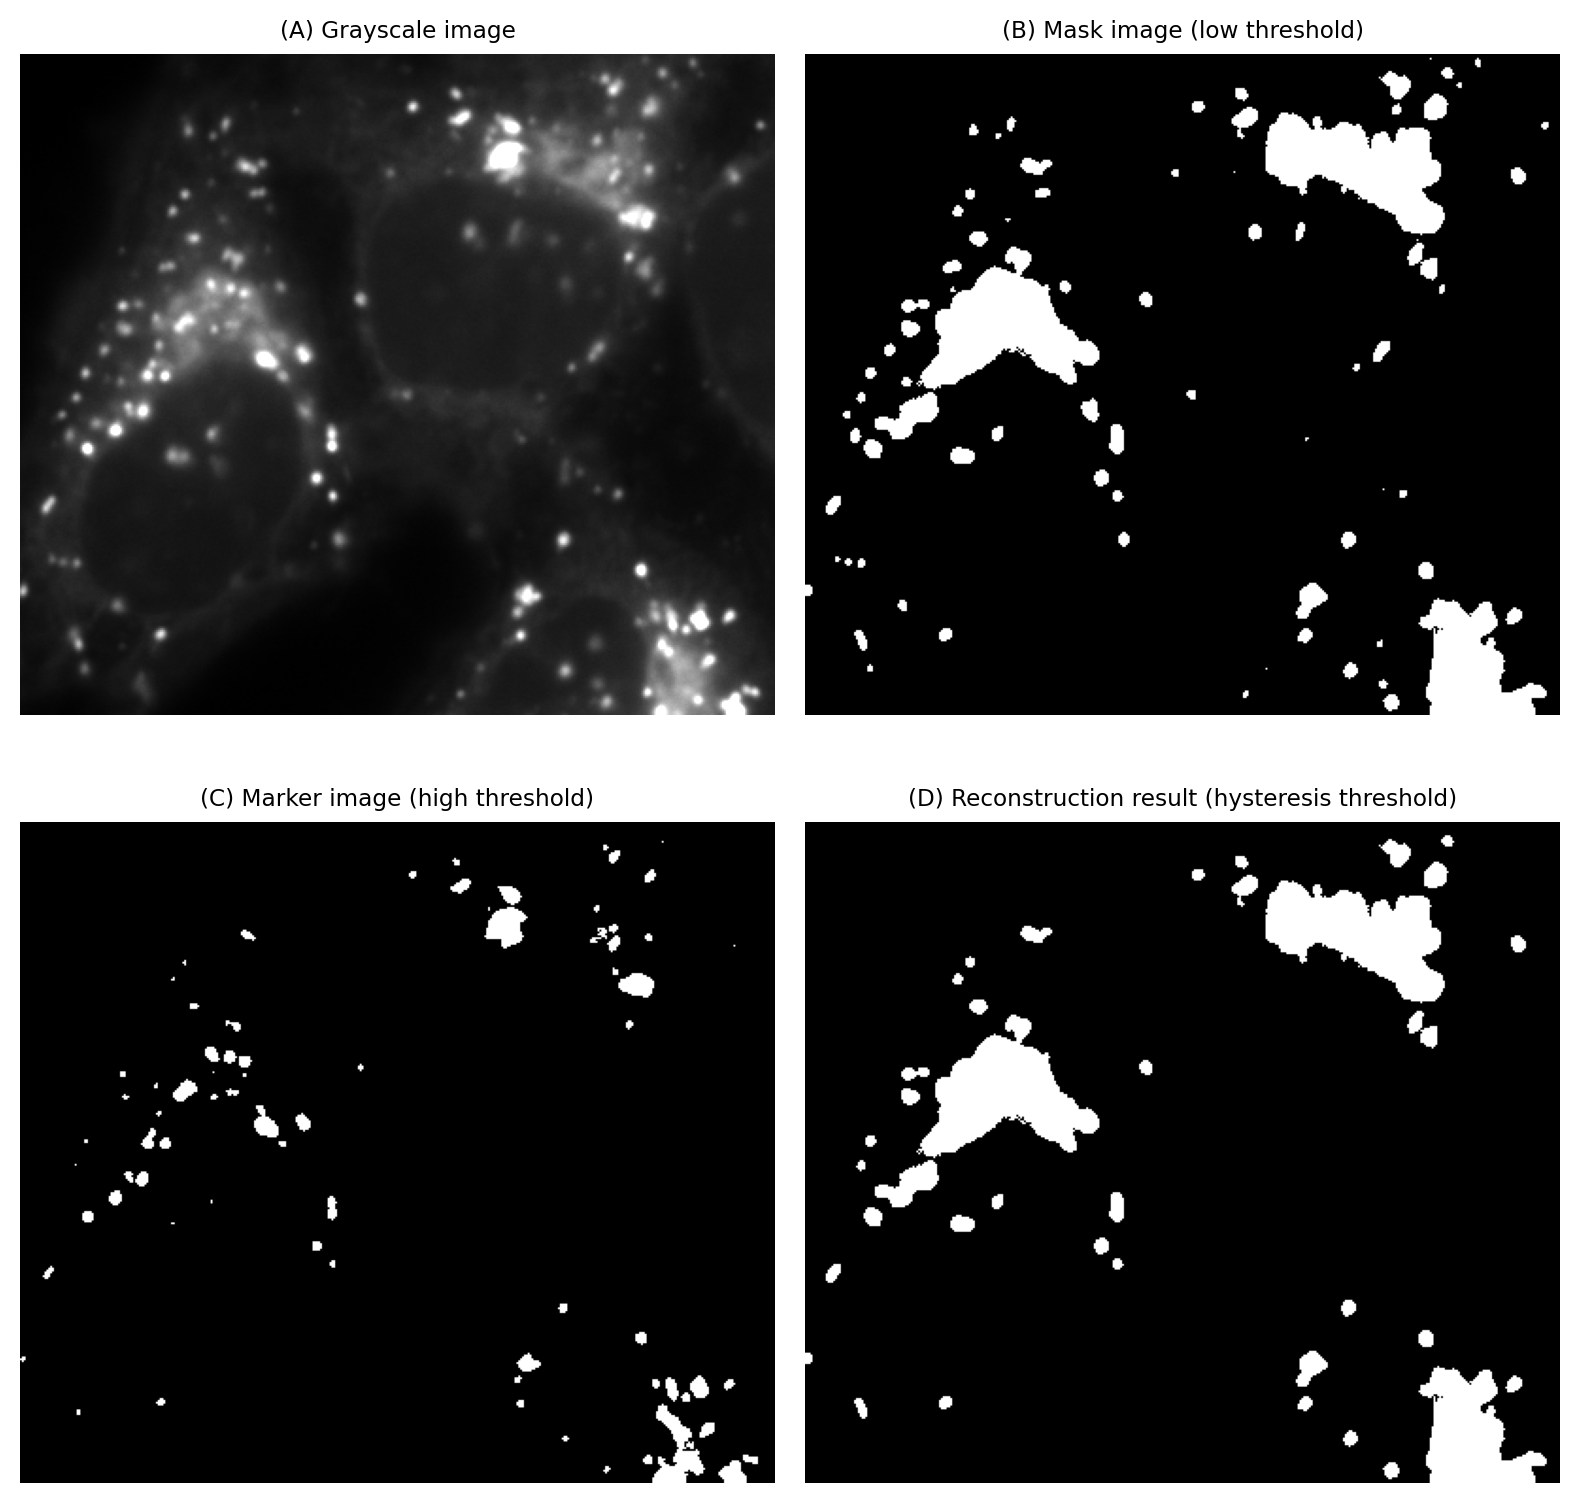

In [12]:
from skimage import morphology as morph

# Load image & process
im = load_spots()
bw_low = im > im.mean() + im.std()
bw_high = im > im.mean() + 3 * im.std()
bw_hist = morph.reconstruction(bw_high, bw_low)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(im, clip_percentile=0.5, title="(A) Grayscale image", pos=221)
show_image(bw_low, title="(B) Mask image (low threshold)", pos=222)
show_image(bw_high, title=f"(C) Marker image (high threshold)", pos=223)
show_image(bw_hist, title=f"(D) Reconstruction result (hysteresis threshold)", pos=224)
plt.tight_layout()

glue_fig('fig_hysteresis_threshold_spots', fig)

```{glue:figure} fig_hysteresis_threshold_spots
---
align: center
name: fig-hysteresis_threshold_spots
---
Applying a hysteresis threshold to an image. The size and area of the objects detected by this method are determined by the low threshold, but at least one of the pixel values within the object must exceed the high threshold. This slightly mitigates the problem of a single global threshold having [a huge impact on analysis results](chap_thresholding), by the same threshold simultaneously influencing both what is detected and its size.
```

(sec_h_extrema)=
### H-Maxima & H-Minima

We [saw previously](fig-morph_simple_maxima) that we could (kind of) identify local maxima in a very simple way using an image dilation, but the results are often too inaccurate to be useful.

**H-Maxima** and **H-Minima** can help us overcome this.
These operations both require only one intuitive parameter: they enable us to identify maxima or minima using a local intensity threshold *H*.

This is achieved using morphological reconstruction.
For H-maxima, the process is:
* Set the original grayscale image as the *mask*
* Subtract *H* from the mask to create the *markers*
* Apply morphological reconstruction using the markers and mask
* Subtract the reconstruction result from the *mask*
* Threshold the subtracted image with a global threshold of *H*

The main steps are illustrated in {numref}`fig-morph_h_maxima`.
We can apply the same process to an inverted image to find *H-minima*.

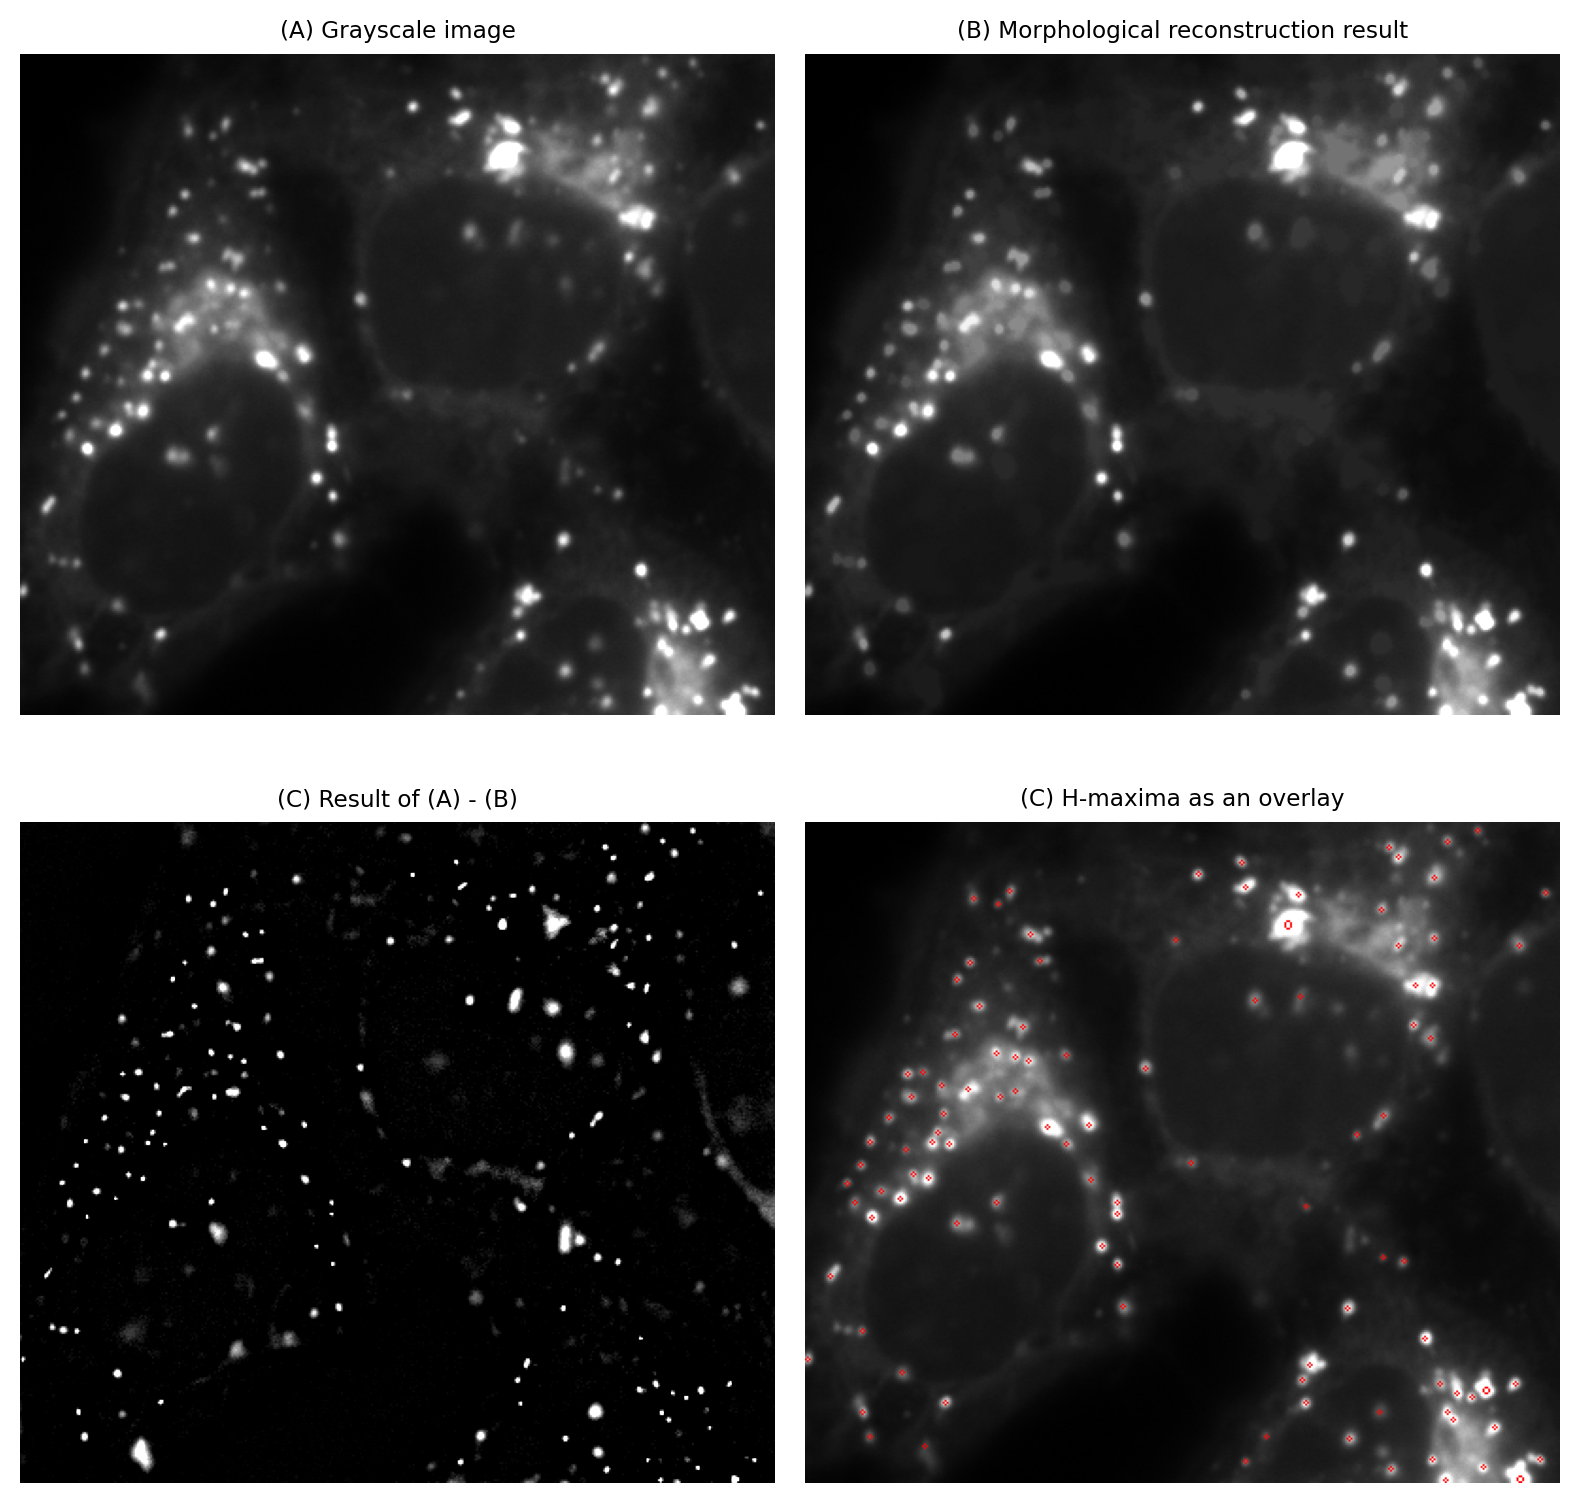

In [13]:
from skimage import morphology as morph
from skimage import filters as filters
from skimage.segmentation import mark_boundaries

# Load image & process
im = load_spots()
h = im.std()
im_recon = morph.reconstruction(im - h, im)

bw = morph.h_maxima(im, h)
im2 = im - np.percentile(im.ravel(), 0.5)
im2 = im2 / np.percentile(im2.ravel(), 99.5)
im_boundaries = mark_boundaries(np.clip(im2, 0, 1), bw, color=(1, 0, 0))

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(im, clip_percentile=0.5, title="(A) Grayscale image", pos=221)
show_image(im_recon, clip_percentile=0.5, title=f"(B) Morphological reconstruction result", pos=222)
show_image(im - im_recon, clip_percentile=0.5, title=f"(C) Result of (A) - (B)", pos=223)
show_image(im_boundaries, title=f"(C) H-maxima as an overlay", pos=224)
plt.tight_layout()

glue_fig('fig_morph_h_maxima', fig)

```{glue:figure} fig_morph_h_maxima
---
align: center
name: fig-morph_h_maxima
---
Calculating H-maxima using morphological reconstruction. Here, *H* is set (arbitrarily) to be the image standard deviation.
```

### Opening & closing by reconstruction

H-maxima and H-minima use morphological reconstruction to effectively generate a background image that can be subtracted from the original.
We do this by subtracting a constant *H*, which acts as a local intensity threshold.

We can also use morphological reconstruction to generate a background image based upon spatial information, rather than an intensity threshold *H*, by using **opening by reconstruction**.
This effectively introduces a size component into our local threshold.
**Closing by reconstruction** is an analogous operation that can be defined using morphological closing.

The starting point for opening by reconstruction is a *morphological opening* [as defined above](sec_morph_opening_closing), i.e. an erosion followed by a dilation.
This defines the marker image.
The original image is used as the mask.

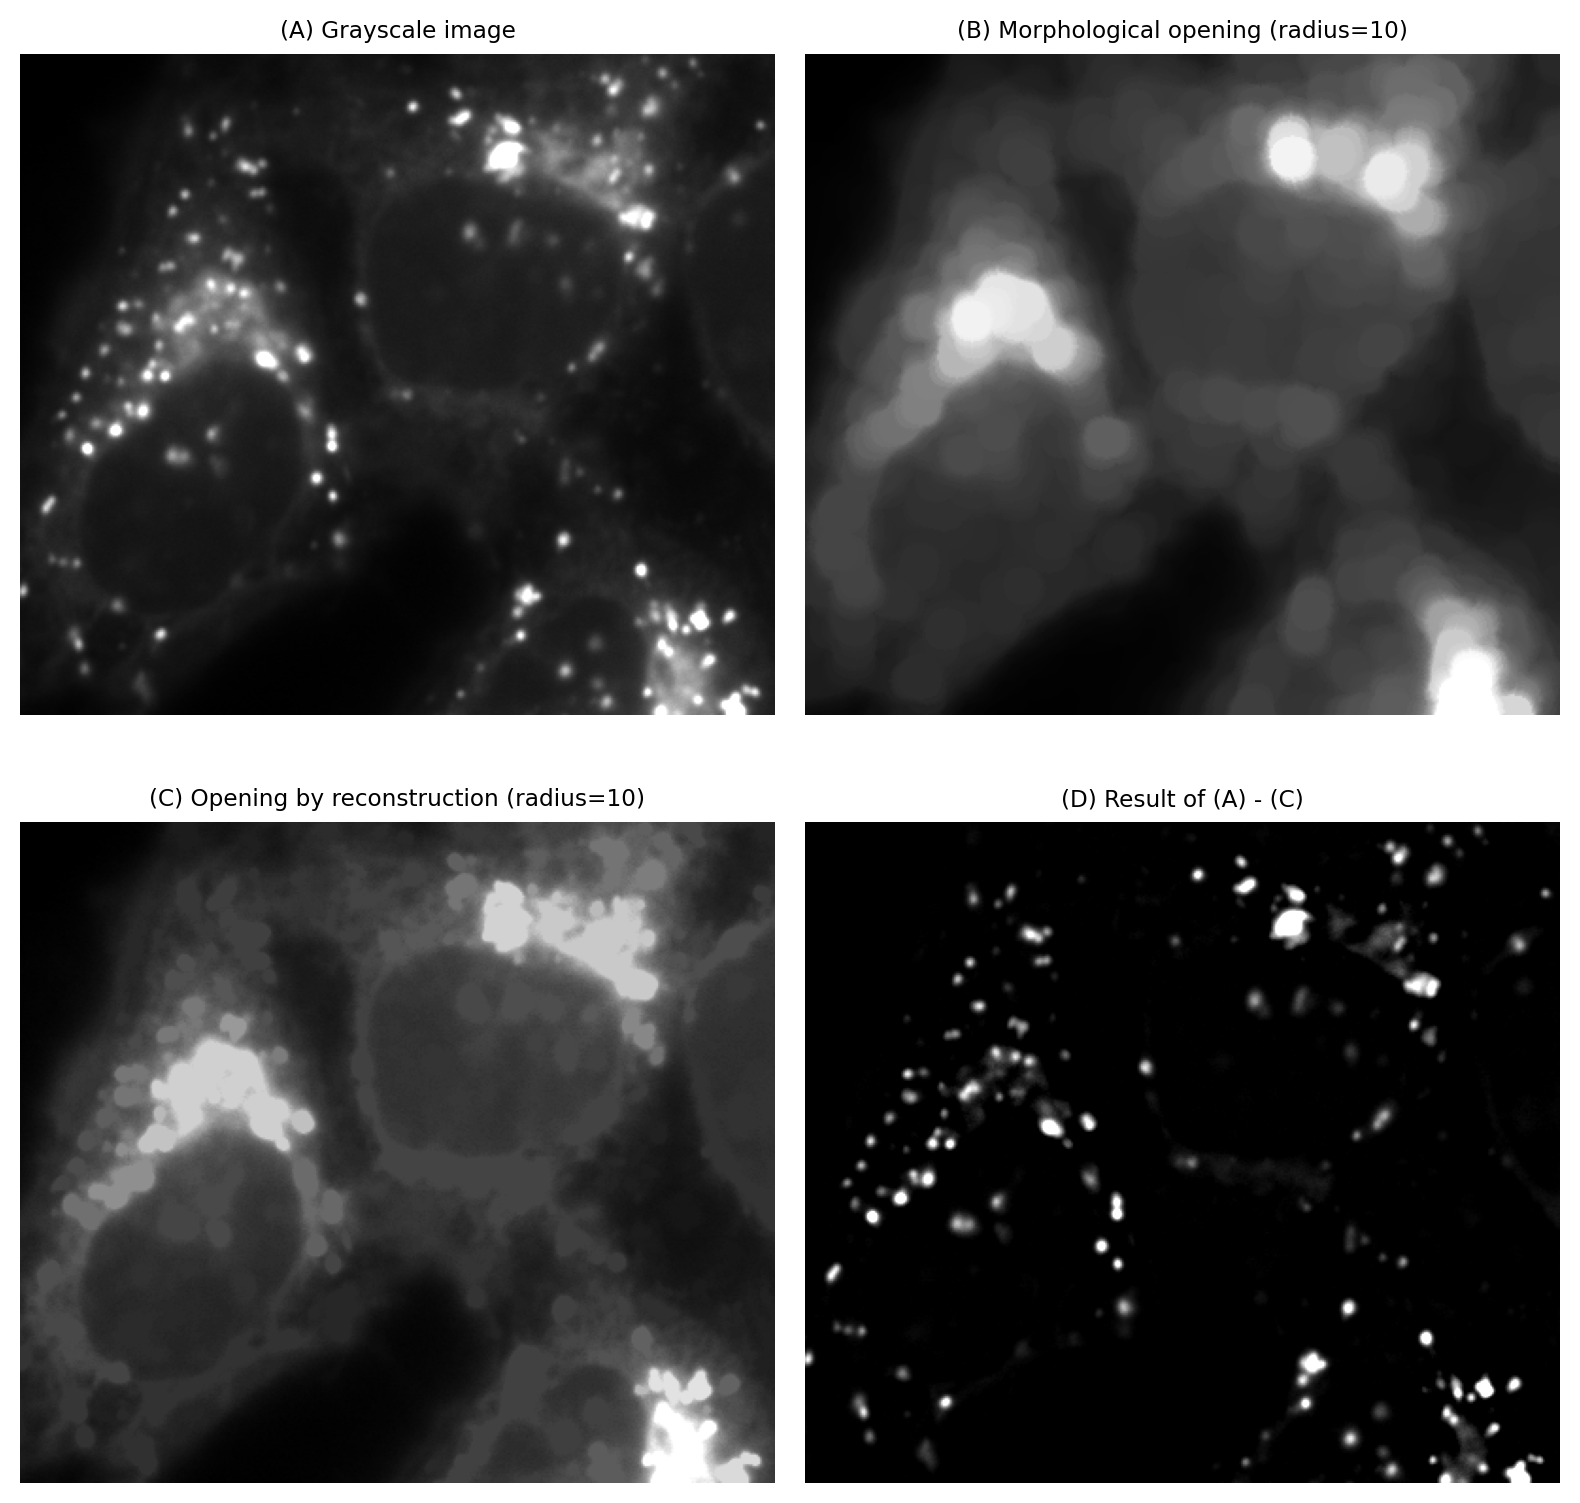

In [14]:
from skimage import morphology as morph

radius = 10

# Load image & process
im = load_spots()
im_open = morph.opening(im, morph.disk(radius))
im_recon = morph.reconstruction(im_open, im)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(im, clip_percentile=0.5, title="(A) Grayscale image", pos=221)
show_image(im_open, clip_percentile=0.5, title=f"(B) Morphological opening (radius={radius})", pos=222)
show_image(im_recon, clip_percentile=0.5, title=f"(C) Opening by reconstruction (radius={radius})", pos=223)
show_image(im - im_recon, clip_percentile=0.5, title=f"(D) Result of (A) - (C)", pos=224)
plt.tight_layout()

glue_fig('fig_morph_reconstruct_opening', fig)

```{glue:figure} fig_morph_reconstruct_opening
---
align: center
name: fig-morph_reconstruct_opening
---
Using opening by reconstruction to obtain a background estimate. The estimate can be subtracted from an image before applying a global threshold.
```

As before, opening alone removes structures that are smaller than the structuring element, while slightly affecting the shapes of everything else.
Opening by reconstruction essentially adds some further (constrained) dilations so that the structures that were *not* removed are more similar to how they were originally.
This can make opening by reconstruction more attractive for generating background images that will be used for subtraction.

Opening by reconstruction can also be applied to binary images as an alternative to *opening* and *area opening*.
Like area opening, opening by reconstruction is able to remove some objects while retaining the shapes of larger objects exactly.

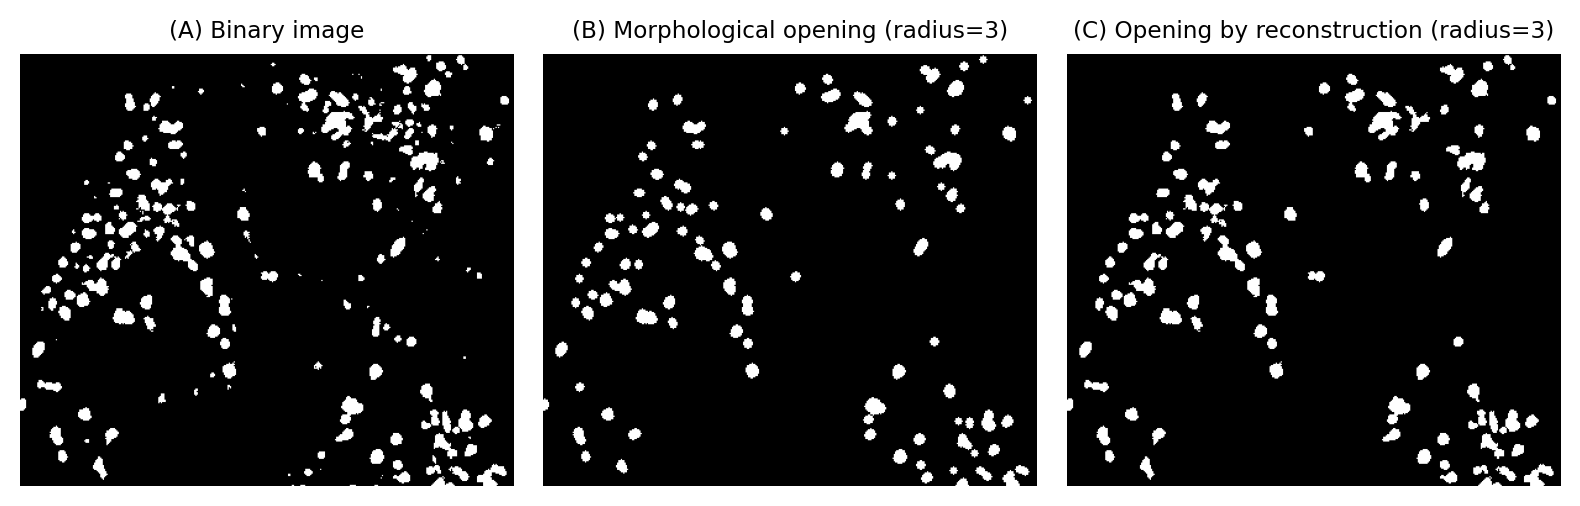

In [15]:
from skimage import morphology as morph

radius = 3

# Load image & process
bw = load_binary_spots()
bw_open = morph.opening(bw, morph.disk(radius))
bw_opening_by_recon = morph.reconstruction(bw_open, bw)

# Show original concatenated with the filtered images
fig = create_figure(figsize=(8, 8))

show_image(bw, title="(A) Binary image", pos=131)
show_image(bw_open, title=f"(B) Morphological opening (radius={radius})", pos=132)
show_image(bw_opening_by_recon, title=f"(C) Opening by reconstruction (radius={radius})", pos=133)
plt.tight_layout()

glue_fig('fig_morph_reconstruct_opening_binary', fig)

```{glue:figure} fig_morph_reconstruct_opening_binary
---
align: center
name: fig-morph_reconstruct_opening_binary
---
Using opening by reconstruction to remove small (and thin) objects from a binary image, while retaining the original shape of everything that remains.
```